In [1]:
import cv2
import numpy as np
import glob
from scipy.signal import find_peaks
import os

# --- 1. ตั้งค่าตัวแปร ---
# !!! สำคัญ: แก้ไข path นี้ให้ตรงกับที่อยู่ไฟล์ของคุณ !!!
# (ใช้ / หรือ \\ สองตัวสำหรับ Windows)
image_path = r"C:\Users\Pannawit\Documents\GitHub\NARIT_Project\1tick_3\1tick_3"
file_pattern = os.path.join(image_path, "image_*.png")

# --- 2. โหลดและเรียงลำดับไฟล์ภาพ ---
# ใช้ glob เพื่อหาไฟล์ทั้งหมดที่ตรงแพทเทิร์น
file_list = glob.glob(file_pattern)

# ตรวจสอบว่าเจอไฟล์หรือไม่
if not file_list:
    print(f"ไม่พบไฟล์ภาพใน: {image_path}")
    print("กรุณาตรวจสอบ path และชื่อไฟล์ (ต้องเป็น .png)")
else:
    # เรียงลำดับไฟล์ตามชื่อ (image_0000, image_0001, ...)
    file_list.sort()
    
    print(f"พบไฟล์ทั้งหมด {len(file_list)} ไฟล์. กำลังเริ่มประมวลผล...")

    # โหลดภาพทั้งหมดมาเก็บใน list (แบบ grayscale)
    all_images = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in file_list]

    # --- 3. หาเส้นอ้างอิง (Reference Lines) จากภาพแรก ---
    
    first_image = all_images[0]
    # เลือกแถวแนวนอนตรงกลางภาพเพื่อวิเคราะห์
    mid_y = first_image.shape[0] // 2
    profile0 = first_image[mid_y, :].astype(float) # โปรไฟล์ความสว่าง
    
    # หา "แถบมืด" (local minima)
    # เราจะหา "ยอด" (peaks) ของสัญญาณที่กลับด้าน (-profile0)
    # distance=20 คือการบอกว่ายอดแต่ละอันต้องห่างกันอย่างน้อย 20 pixels
    minima_indices, _ = find_peaks(-profile0, distance=20)
    
    if len(minima_indices) < 2:
        print("เกิดข้อผิดพลาด: ไม่สามารถหาแถบมืดในภาพแรกได้")
        print("อาจจะต้องปรับค่า 'distance' ใน find_peaks")
    else:
        # "แถบดำอันแรกทางขวามือ" คืออันสุดท้ายใน list ที่เราหาเจอ
        ref_A_x = minima_indices[-1]
        
        # คำนวณความกว้างเฉลี่ยของแถบ (fringe spacing)
        spacing = np.mean(np.diff(minima_indices))
        
        # หาตำแหน่งเซ็นเซอร์ตัวที่สอง (B) โดยขยับไป 1/4 ของความกว้างแถบ
        # นี่คือหัวใจของ Quadrature Detection
        quadrature_offset = int(np.round(spacing / 4))
        ref_B_x = ref_A_x - quadrature_offset # ขยับไปทางซ้าย
        
        print(f"ตั้งค่าเส้นอ้างอิงที่แกน Y = {mid_y}")
        print(f"เซ็นเซอร์ A (อ้างอิง) ที่ X = {ref_A_x}")
        print(f"เซ็นเซอร์ B (ทิศทาง) ที่ X = {ref_B_x}")

        # --- 4. วนลูปนับแถบ (Quadrature Counting) ---
        
        # ตารางสถานะ (A, B) -> ค่า Quadrature
        # (0=มืด, 1=สว่าง)
        lookup_table = {
            (0, 0): 0,  # มืด, มืด
            (0, 1): 1,  # มืด, สว่าง
            (1, 1): 2,  # สว่าง, สว่าง
            (1, 0): 3   # สว่าง, มืด
        }
        
        total_quadrature_steps = 0
        prev_state = None
        
        for img in all_images:
            # ดึงโปรไฟล์ความสว่างจากแถวกลาง
            profile = img[mid_y, :].astype(float)
            
            # หาค่า threshold (กึ่งกลางระหว่างมืดสุดกับสว่างสุด) ของภาพนี้
            threshold = (np.min(profile) + np.max(profile)) / 2.0
            
            # เช็คสถานะ "มืด" (0) หรือ "สว่าง" (1) ที่จุด A และ B
            state_A = 1 if profile[ref_A_x] > threshold else 0
            state_B = 1 if profile[ref_B_x] > threshold else 0
            
            current_state = (state_A, state_B)
            
            # ถ้าเป็นเฟรมแรก ให้ตั้งค่าเริ่มต้น
            if prev_state is None:
                prev_state = current_state
                continue
                
            # ถ้าสถานะไม่เปลี่ยน ก็ข้ามไปเฟรมถัดไป
            if current_state == prev_state:
                continue

            # แปลงสถานะ (A, B) เป็นค่า 0, 1, 2, 3
            last_q_val = lookup_table[prev_state]
            current_q_val = lookup_table[current_state]
            
            # คำนวณการเปลี่ยนแปลง
            diff = current_q_val - last_q_val
            
            # จัดการการ "วนลูป" (เช่น จาก 3 ไป 0 หรือ 0 ไป 3)
            if diff == 3:  # หมุนย้อนกลับ (เช่น 3 -> 0)
                diff = -1
            elif diff == -3: # หมุนไปข้างหน้า (เช่น 0 -> 3)
                diff = 1
            elif abs(diff) > 1: # ถ้าข้ามขั้น (เช่น 0 -> 2) แสดงว่ามี noise, ให้ข้ามไป
                diff = 0
                
            # สะสมการเคลื่อนที่
            total_quadrature_steps += diff
            
            # อัปเดตสถานะก่อนหน้า
            prev_state = current_state
            
        # --- 5. แสดงผลลัพธ์ ---
        # 1 แถบ = 4 ขั้นตอน quadrature (0->1->2->3->0)
        net_fringe_count = total_quadrature_steps / 4.0
        
        print("\n--- ผลลัพธ์ ---")
        print(f"จำนวน Quadrature Steps สุทธิ: {total_quadrature_steps}")
        print(f"จำนวนแถบมืด (สุทธิ) ที่นับได้: {net_fringe_count}")

พบไฟล์ทั้งหมด 240 ไฟล์. กำลังเริ่มประมวลผล...
ตั้งค่าเส้นอ้างอิงที่แกน Y = 200
เซ็นเซอร์ A (อ้างอิง) ที่ X = 992
เซ็นเซอร์ B (ทิศทาง) ที่ X = 985

--- ผลลัพธ์ ---
จำนวน Quadrature Steps สุทธิ: 0
จำนวนแถบมืด (สุทธิ) ที่นับได้: 0.0


In [2]:
import cv2
import numpy as np
import glob
from scipy.signal import find_peaks, hilbert
import os
import matplotlib.pyplot as plt # เพิ่มมาเพื่อ visualize

# --- 1. ตั้งค่าตัวแปร ---
# !!! สำคัญ: แก้ไข path นี้ให้ตรงกับที่อยู่ไฟล์ของคุณ !!!
# (ใช้ / หรือ \\ สองตัวสำหรับ Windows)
image_path = r"C:\Users\Pannawit\Documents\GitHub\NARIT_Project\1tick_3\1tick_3"
file_pattern = os.path.join(image_path, "image_*.png")

# --- 2. โหลดและเรียงลำดับไฟล์ภาพ ---
file_list = glob.glob(file_pattern)

if not file_list:
    print(f"ไม่พบไฟล์ภาพใน: {image_path}")
    print("กรุณาตรวจสอบ path และชื่อไฟล์ (ต้องเป็น .png)")
    exit() # ออกจากโปรแกรมถ้าไม่เจอไฟล์

file_list.sort()
print(f"พบไฟล์ทั้งหมด {len(file_list)} ไฟล์. กำลังเริ่มประมวลผล...")

# โหลดภาพทั้งหมดมาเก็บใน list (แบบ grayscale)
all_images = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in file_list]

# --- 3. ตั้งค่าจุดอ้างอิงสำหรับโปรไฟล์ ---
mid_y = all_images[0].shape[0] // 2 # ใช้แถวแนวนอนตรงกลาง

# --- 4. การประมวลผลเฟส (Phase Unwrapping) ---
# เราจะเก็บค่าเฟสของแต่ละภาพ
phase_values = []
prev_phase = 0 # สำหรับการ unwrap phase

# เพิ่มส่วนสำหรับ visualize
# plt.figure(figsize=(12, 6))
# plt.title("Intensity Profile and Detected Peaks (First Image)")

for i, img in enumerate(all_images):
    profile = img[mid_y, :].astype(float)
    
    # ทำให้โปรไฟล์เป็น "AC coupled" คือเอาค่าเฉลี่ยออก
    profile_dc_removed = profile - np.mean(profile)

    # ใช้ Hilbert Transform เพื่อหา Analytic Signal
    # จาก Analytic Signal เราสามารถหา Amplitude และ Phase ได้
    analytic_signal = hilbert(profile_dc_removed)
    instantaneous_phase = np.arctan2(np.imag(analytic_signal), np.real(analytic_signal))
    
    # เราสนใจเฟสที่ตำแหน่ง "กลาง" หรือ "แถบมืดแรกทางขวา" ของภาพ
    # เพื่อให้ง่าย เราจะใช้ตำแหน่ง X ที่มีค่าความสว่างน้อยที่สุด (แถบมืด) จากภาพแรกเป็นจุดอ้างอิง
    
    # ในการทำ Phase Detection เราไม่จำเป็นต้องมี ref_A_x และ ref_B_x แบบ binary อีกต่อไป
    # เราจะเลือกจุด X จุดเดียวบนโปรไฟล์ที่ต้องการติดตามเฟส
    
    # เราจะหาตำแหน่งแถบมืดแรกทางขวาจากภาพแรก
    if i == 0:
        # หา "แถบมืด" (local minima)
        # เราจะหา "ยอด" (peaks) ของสัญญาณที่กลับด้าน (-profile)
        minima_indices, _ = find_peaks(-profile, distance=20) # ต้องปรับ distance ให้เหมาะสม
        
        if len(minima_indices) == 0:
            print("เกิดข้อผิดพลาด: ไม่สามารถหาแถบมืดในภาพแรกได้")
            print("อาจจะต้องปรับค่า 'distance' ใน find_peaks")
            exit()
            
        # เลือกตำแหน่งแถบมืดสุดท้ายทางขวามือเป็นจุดอ้างอิง (ref_x)
        ref_x = minima_indices[-1]
        print(f"ตั้งค่าเส้นอ้างอิงสำหรับติดตามเฟสที่แกน Y = {mid_y}, X = {ref_x}")

        # # Debug: Plotting for the first image
        # plt.plot(profile, label='Intensity Profile')
        # plt.plot(minima_indices, profile[minima_indices], "x", label='Detected Minima')
        # plt.axvline(x=ref_x, color='r', linestyle='--', label=f'Reference X = {ref_x}')
        # plt.legend()
        # plt.show()
    
    # ดึงค่าเฟสที่ตำแหน่งอ้างอิง
    current_phase = instantaneous_phase[ref_x]
    
    # Phase Unwrapping: แก้ปัญหาการกระโดดจาก pi เป็น -pi
    # ถ้าค่าเฟสกระโดดเกิน threshold (เช่น pi -> -pi) ให้ปรับแก้
    diff_phase = current_phase - prev_phase
    if diff_phase > np.pi:
        current_phase -= 2 * np.pi
    elif diff_phase < -np.pi:
        current_phase += 2 * np.pi
        
    phase_values.append(current_phase)
    prev_phase = current_phase

# --- 5. คำนวณการเคลื่อนที่ของแถบ ---

# แปลง phase_values ให้เป็น numpy array
phase_values = np.array(phase_values)

# Shift the first phase value to be 0 for easier interpretation
# (อันนี้เป็นการ normalize ให้กราฟเริ่มต้นที่ 0 เพื่อให้ดูง่ายขึ้น)
phase_values -= phase_values[0]

# Phase change per fringe is 2*pi radians
# จำนวนแถบที่เคลื่อนที่ = (การเปลี่ยนแปลงเฟสทั้งหมด) / (2 * pi)
total_phase_change = phase_values[-1] - phase_values[0]
net_fringe_count = total_phase_change / (2 * np.pi)

print("\n--- ผลลัพธ์ ---")
print(f"การเปลี่ยนแปลงเฟสสุทธิ (เรเดียน): {total_phase_change:.2f}")
print(f"จำนวนแถบมืด (สุทธิ) ที่นับได้: {net_fringe_count:.2f}")

# Optional: Plotting the phase change over time
# plt.figure(figsize=(12, 6))
# plt.plot(np.arange(len(phase_values)), phase_values / (2 * np.pi), label='Net Fringe Count')
# plt.xlabel("Frame Number")
# plt.ylabel("Net Fringe Count")
# plt.title("Net Fringe Count over Frames")
# plt.grid(True)
# plt.legend()
# plt.show()

พบไฟล์ทั้งหมด 240 ไฟล์. กำลังเริ่มประมวลผล...
ตั้งค่าเส้นอ้างอิงสำหรับติดตามเฟสที่แกน Y = 200, X = 992

--- ผลลัพธ์ ---
การเปลี่ยนแปลงเฟสสุทธิ (เรเดียน): -0.25
จำนวนแถบมืด (สุทธิ) ที่นับได้: -0.04


In [3]:
import cv2
import numpy as np
import glob
from scipy.signal import find_peaks
import os
import sys # ใช้สำหรับ exit

# --- 1. ตั้งค่าตัวแปร ---
image_path = r"C:\Users\Pannawit\Documents\GitHub\NARIT_Project\1tick_3\1tick_3"
file_pattern = os.path.join(image_path, "image_*.png")
PEAK_DISTANCE_THRESHOLD = 20 # ระยะห่างขั้นต่ำระหว่างแถบ (pixels)

# --- 2. โหลดและเรียงลำดับไฟล์ภาพ ---
file_list = glob.glob(file_pattern)

if not file_list:
    print(f"ไม่พบไฟล์ภาพใน: {image_path}")
    sys.exit("กรุณาตรวจสอบ path และชื่อไฟล์")

file_list.sort()
print(f"พบไฟล์ทั้งหมด {len(file_list)} ไฟล์. กำลังเริ่มประมวลผล...")

all_images = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in file_list]

# --- 3. วิเคราะห์ภาพแรก (Frame 0) ---
first_image = all_images[0]
mid_y = first_image.shape[0] // 2
profile0 = first_image[mid_y, :].astype(float)

# หา "แถบมืด" (minima)
minima_indices, _ = find_peaks(-profile0, distance=PEAK_DISTANCE_THRESHOLD)

if len(minima_indices) < 2:
    print(f"เกิดข้อผิดพลาด: พบแถบมืดน้อยกว่า 2 แถบในภาพแรก (ที่ y={mid_y})")
    print("อาจจะต้องปรับค่า PEAK_DISTANCE_THRESHOLD")
    sys.exit()

# คำนวณความกว้างเฉลี่ยของแถบ (avg spacing)
avg_spacing = np.mean(np.diff(minima_indices))
if avg_spacing <= 0:
    print("เกิดข้อผิดพลาด: ไม่สามารถคำนวณความกว้างแถบได้")
    sys.exit()
    
# "แถบดำอันแรกทางขวามือ" คืออันสุดท้ายใน list
start_pos_x = minima_indices[-1]
current_target_x = start_pos_x

print(f"ตั้งค่าแถววิเคราะห์ที่ Y = {mid_y}")
print(f"แถบอ้างอิงเริ่มต้นที่ X = {current_target_x}")
print(f"คำนวณความกว้างเฉลี่ยของแถบได้ = {avg_spacing:.2f} pixels")

# --- 4. วนลูปติดตามแถบ (Fringe Tracking) ---
tracked_positions = [current_target_x] # เก็บตำแหน่ง X ของแถบในแต่ละเฟรม

# วนลูปตั้งแต่ภาพที่ 1 เป็นต้นไป (ภาพที่ 0 เราใช้ตั้งค่าแล้ว)
for i, img in enumerate(all_images[1:]):
    frame_number = i + 1
    profile = img[mid_y, :].astype(float)
    
    # หาแถบมืดทั้งหมดในเฟรมปัจจุบัน
    new_minima, _ = find_peaks(-profile, distance=PEAK_DISTANCE_THRESHOLD)
    
    if len(new_minima) == 0:
        print(f"คำเตือน: ไม่พบแถบมืดในเฟรมที่ {frame_number}! ใช้ตำแหน่งเดิม ({current_target_x})")
        tracked_positions.append(current_target_x)
        continue
        
    # หาว่าแถบมืดอันไหน "ใกล้" ตำแหน่ง target เดิมของเรามากที่สุด
    distances = np.abs(new_minima - current_target_x)
    closest_index = np.argmin(distances)
    
    # อัปเดตตำแหน่ง target ใหม่
    current_target_x = new_minima[closest_index]
    tracked_positions.append(current_target_x)

# --- 5. สรุปผลลัพธ์ ---
end_pos_x = tracked_positions[-1]

# ระยะทางที่เคลื่อนที่ไปทั้งหมด (หน่วย pixels)
# ถ้าขวาไปซ้าย (เช่น 992 -> 850) ค่านี้จะเป็นบวก
total_displacement_pixels = start_pos_x - end_pos_x

# จำนวนแถบ = ระยะทาง (pixels) / ความกว้างแถบ (pixels/fringe)
net_fringe_count = total_displacement_pixels / avg_spacing

print("\n--- ผลลัพธ์ (Fringe Tracking) ---")
print(f"ตำแหน่งเริ่มต้นของแถบ: {start_pos_x} (ที่ Frame 0)")
print(f"ตำแหน่งสิ้นสุดของแถบ: {end_pos_x} (ที่ Frame {len(all_images)-1})")
print(f"ระยะเคลื่อนที่สุทธิ: {total_displacement_pixels:.2f} pixels")
print(f"ความกว้างแถบเฉลี่ย: {avg_spacing:.2f} pixels/fringe")
print("---")
print(f"จำนวนแถบมืด (สุทธิ) ที่นับได้: {net_fringe_count:.2f}")

พบไฟล์ทั้งหมด 240 ไฟล์. กำลังเริ่มประมวลผล...
ตั้งค่าแถววิเคราะห์ที่ Y = 200
แถบอ้างอิงเริ่มต้นที่ X = 992
คำนวณความกว้างเฉลี่ยของแถบได้ = 26.78 pixels

--- ผลลัพธ์ (Fringe Tracking) ---
ตำแหน่งเริ่มต้นของแถบ: 992 (ที่ Frame 0)
ตำแหน่งสิ้นสุดของแถบ: 988 (ที่ Frame 239)
ระยะเคลื่อนที่สุทธิ: 4.00 pixels
ความกว้างแถบเฉลี่ย: 26.78 pixels/fringe
---
จำนวนแถบมืด (สุทธิ) ที่นับได้: 0.15


In [4]:
import cv2
import numpy as np
import glob
from scipy.signal import find_peaks
import os
import sys

# --- 1. ตั้งค่า ---
image_path = r"C:\Users\Pannawit\Documents\GitHub\NARIT_Project\1tick_3\1tick_3"
first_image_file = os.path.join(image_path, "image_0000.png")
PEAK_DISTANCE_THRESHOLD = 20 # ระยะห่างขั้นต่ำระหว่างแถบ (pixels)

# --- 2. โหลดภาพแรกภาพเดียว ---
if not os.path.exists(first_image_file):
    print(f"ไม่พบไฟล์ภาพ: {first_image_file}")
    sys.exit()

first_image = cv2.imread(first_image_file, cv2.IMREAD_GRAYSCALE)
print(f"กำลังวิเคราะห์ไฟล์: {first_image_file}")

# --- 3. วิเคราะห์หาแถบมืด ---
mid_y = first_image.shape[0] // 2
profile = first_image[mid_y, :].astype(float)

# หา "แถบมืด" (minima)
minima_indices, _ = find_peaks(-profile, distance=PEAK_DISTANCE_THRESHOLD)

# --- 4. สรุปผล ---
count = len(minima_indices)

print("\n--- ผลลัพธ์ (วิธีที่ 1: นับในภาพแรก) ---")
print(f"วิเคราะห์ที่แถว Y = {mid_y}")
print(f"ตำแหน่งแถบมืดที่พบ (X): {minima_indices}")
print(f"จำนวนแถบมืดทั้งหมดที่นับได้ในภาพแรก: {count} แถบ")

กำลังวิเคราะห์ไฟล์: C:\Users\Pannawit\Documents\GitHub\NARIT_Project\1tick_3\1tick_3\image_0000.png

--- ผลลัพธ์ (วิธีที่ 1: นับในภาพแรก) ---
วิเคราะห์ที่แถว Y = 200
ตำแหน่งแถบมืดที่พบ (X): [  1  31  62  86 123 147 179 202 227 252 291 315 343 376 401 421 457 480
 506 542 565 588 611 633 655 683 709 729 751 787 807 831 859 881 907 939
 967 992]
จำนวนแถบมืดทั้งหมดที่นับได้ในภาพแรก: 38 แถบ


In [5]:
import cv2
import numpy as np
import glob
from scipy.signal import find_peaks
import os
import sys

# --- 1. ตั้งค่า ---
image_path = r"C:\Users\Pannawit\Documents\GitHub\NARIT_Project\1tick_3\1tick_3"
file_pattern = os.path.join(image_path, "image_*.png")
PEAK_DISTANCE_THRESHOLD = 20 # ระยะห่างขั้นต่ำระหว่างแถบ (pixels)

# --- 2. โหลดไฟล์ ---
file_list = glob.glob(file_pattern)
if not file_list:
    print(f"ไม่พบไฟล์ภาพใน: {image_path}")
    sys.exit("กรุณาตรวจสอบ path")

file_list.sort()
all_images = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in file_list]
print(f"พบไฟล์ทั้งหมด {len(all_images)} ไฟล์. กำลังเริ่มประมวลผล...")

# --- 3. หาจุดอ้างอิง A และ B จากภาพแรก ---
first_image = all_images[0]
mid_y = first_image.shape[0] // 2
profile0 = first_image[mid_y, :].astype(float)

# หาแถบมืด (minima)
minima_indices, _ = find_peaks(-profile0, distance=PEAK_DISTANCE_THRESHOLD)

if len(minima_indices) < 2:
    print(f"เกิดข้อผิดพลาด: พบแถบมืดน้อยกว่า 2 แถบในภาพแรก (ที่ y={mid_y})")
    print("อาจจะต้องปรับค่า PEAK_DISTANCE_THRESHOLD")
    sys.exit()

# คำนวณความกว้างเฉลี่ยของแถบ
avg_spacing = np.mean(np.diff(minima_indices))
if avg_spacing <= 0:
    print("เกิดข้อผิดพลาด: ไม่สามารถคำนวณความกว้างแถบได้")
    sys.exit()

# A = แถบมืดขวาสุด
ref_A_x = minima_indices[-1]
# B = จุดที่ห่างจาก A ไป 1/4 ของความกว้างแถบ
ref_B_x = int(ref_A_x - avg_spacing / 4.0) 

# ตรวจสอบว่า B ไม่ตกขอบ
if ref_B_x < 0:
    print(f"คำเตือน: ตำแหน่ง B ({ref_B_x}) ตกขอบ, อาจจะคำนวณผิดพลาด")
    ref_B_x = 0

print(f"ตั้งค่าแถววิเคราะห์ที่ Y = {mid_y}")
print(f"ความกว้างแถบเฉลี่ย: {avg_spacing:.2f} pixels")
print(f"เซ็นเซอร์ A (อ้างอิง) ที่ X = {ref_A_x}")
print(f"เซ็นเซอร์ B (ทิศทาง) ที่ X = {ref_B_x}")

# --- 4. วนลูปเพื่อดึงค่าเฟส (Phase) ---
all_phases = []

for img in all_images:
    profile = img[mid_y, :].astype(float)
    
    # Normalization: ทำให้สัญญาณอยู่ระหว่าง -0.5 ถึง 0.5
    # นี่คือขั้นตอนสำคัญที่ทำให้ทนทานต่อการเปลี่ยนแปลงความสว่าง
    min_val = np.min(profile)
    max_val = np.max(profile)
    denom = max_val - min_val
    if denom < 1e-6: # ป้องกันการหารด้วย 0 ถ้าภาพมืด/สว่างเท่ากันหมด
        denom = 1.0 
        
    norm_profile = (profile - min_val) / denom
    
    # ดึงค่าที่ A และ B (ตอนนี้จะอยู่ระหว่าง 0 ถึง 1)
    # แล้วลบ 0.5 เพื่อให้มันแกว่งรอบ 0 (เป็น AC signal)
    signal_A = norm_profile[ref_A_x] - 0.5
    signal_B = norm_profile[ref_B_x] - 0.5
    
    # คำนวณเฟส
    current_phase = np.arctan2(signal_B, signal_A)
    all_phases.append(current_phase)

# --- 5. Phase Unwrapping และนับจำนวน ---
# np.unwrap คือฟังก์ชันวิเศษที่จะจัดการการกระโดดของเฟส (จาก pi ไป -pi)
# มันจะบวก/ลบ 2*pi ให้เราอัตโนมัติ
unwrapped_phases = np.unwrap(all_phases)

# การเปลี่ยนแปลงเฟสทั้งหมด (หน่วยเรเดียน)
total_phase_change = unwrapped_phases[-1] - unwrapped_phases[0]

# 1 แถบ = 2*pi เรเดียน
net_fringe_count = total_phase_change / (2 * np.pi)

print("\n--- ผลลัพธ์ (Robust Quadrature) ---")
print(f"เฟสเริ่มต้น (เรเดียน): {unwrapped_phases[0]:.2f}")
print(f"เฟสสิ้นสุด (เรเดียน): {unwrapped_phases[-1]:.2f}")
print(f"การเปลี่ยนแปลงเฟสสุทธิ: {total_phase_change:.2f} เรเดียน")
print("---")
print(f"จำนวนแถบมืด (สุทธิ) ที่นับได้: {net_fringe_count:.2f}")

# # Optional: ถ้าอยากเห็นกราฟการเคลื่อนที่
# import matplotlib.pyplot as plt
# plt.figure(figsize=(10, 4))
# plt.plot(np.arange(len(unwrapped_phases)), unwrapped_phases / (2 * np.pi))
# plt.title("Net Fringe Count Over Time")
# plt.xlabel("Frame Number")
# plt.ylabel("Net Fringes")
# plt.grid(True)
# plt.show()

พบไฟล์ทั้งหมด 240 ไฟล์. กำลังเริ่มประมวลผล...
ตั้งค่าแถววิเคราะห์ที่ Y = 200
ความกว้างแถบเฉลี่ย: 26.78 pixels
เซ็นเซอร์ A (อ้างอิง) ที่ X = 992
เซ็นเซอร์ B (ทิศทาง) ที่ X = 985

--- ผลลัพธ์ (Robust Quadrature) ---
เฟสเริ่มต้น (เรเดียน): -2.38
เฟสสิ้นสุด (เรเดียน): -2.37
การเปลี่ยนแปลงเฟสสุทธิ: 0.01 เรเดียน
---
จำนวนแถบมืด (สุทธิ) ที่นับได้: 0.00


In [6]:
import cv2
import numpy as np
import glob
from scipy.signal import find_peaks
import os
import sys

# --- 1. ตั้งค่า ---
image_path = r"C:\Users\Pannawit\Documents\GitHub\NARIT_Project\1tick_3\1tick_3"
file_pattern = os.path.join(image_path, "image_*.png")
# เราจะใช้ค่านี้เพื่อหา peaks, 15-20 pixel น่าจะโอเค
PEAK_DISTANCE_THRESHOLD = 20 

# ค่า Calibration ที่คุณให้มา
EXPECTED_COUNT = 50.0
FRINGES_PER_MICRON = 2.5

# --- 2. โหลดไฟล์ ---
file_list = glob.glob(file_pattern)
if not file_list:
    print(f"ไม่พบไฟล์ภาพใน: {image_path}")
    sys.exit("กรุณาตรวจสอบ path")

file_list.sort()
all_images = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in file_list]
print(f"พบไฟล์ทั้งหมด {len(all_images)} ไฟล์.")

# --- 3. คำนวณความกว้างแถบ (avg_spacing) จากภาพแรก ---
first_image = all_images[0]
mid_y = first_image.shape[0] // 2
profile0 = first_image[mid_y, :].astype(float)

# หา "แถบมืด" (minima) ทั้งหมดในแถวกลาง
minima_indices, _ = find_peaks(-profile0, distance=PEAK_DISTANCE_THRESHOLD)

if len(minima_indices) < 2:
    print(f"เกิดข้อผิดพลาด: พบแถบมืดน้อยกว่า 2 แถบในภาพแรก (ที่ y={mid_y})")
    print(f"ลองปรับค่า PEAK_DISTANCE_THRESHOLD (ปัจจุบันคือ {PEAK_DISTANCE_THRESHOLD})")
    sys.exit()

# คำนวณความกว้างเฉลี่ยของแถบ (avg spacing)
# โดยการหาค่าเฉลี่ยของระยะห่างระหว่างแถบที่พบทั้งหมด
avg_spacing = np.mean(np.diff(minima_indices))
print(f"คำนวณความกว้างแถบเฉลี่ย (Avg Spacing) ได้ = {avg_spacing:.2f} pixels/fringe")

# --- 4. ติดตามแถบ (Fringe Tracking) ---
# "แถบดำอันแรกทางขวามือ" คืออันสุดท้ายใน list
start_pos_x = minima_indices[-1]
current_target_x = start_pos_x

print(f"ตั้งค่าแถววิเคราะห์ที่ Y = {mid_y}")
print(f"แถบอ้างอิงเริ่มต้น (ขวาสุด) ที่ X = {current_target_x} (ใน Frame 0)")

tracked_positions = [current_target_x] # เก็บตำแหน่ง X ของแถบในแต่ละเฟรม

# วนลูปตั้งแต่ภาพที่ 1 เป็นต้นไป
for i, img in enumerate(all_images[1:]):
    profile = img[mid_y, :].astype(float)
    
    # หาแถบมืดทั้งหมดในเฟรมปัจจุบัน
    new_minima, _ = find_peaks(-profile, distance=PEAK_DISTANCE_THRESHOLD)
    
    if len(new_minima) == 0:
        # ถ้าหาไม่เจอเลย (เช่น ภาพเบลอ) ให้ใช้ตำแหน่งล่าสุดไปก่อน
        tracked_positions.append(current_target_x)
        continue
        
    # หาว่าแถบมืดอันไหน "ใกล้" ตำแหน่ง target เดิมของเรามากที่สุด
    distances = np.abs(new_minima - current_target_x)
    closest_index = np.argmin(distances)
    
    # อัปเดตตำแหน่ง target ใหม่
    current_target_x = new_minima[closest_index]
    tracked_positions.append(current_target_x)

# --- 5. สรุปผลลัพธ์ ---
end_pos_x = tracked_positions[-1]

# ระยะทางที่เคลื่อนที่ไปทั้งหมด (หน่วย pixels)
# ถ้าขวาไปซ้าย (เช่น 992 -> 492) ค่านี้จะเป็นบวก
total_displacement_pixels = start_pos_x - end_pos_x

# จำนวนแถบ = ระยะทาง (pixels) / ความกว้างแถบ (pixels/fringe)
net_fringe_count = total_displacement_pixels / avg_spacing

# คำนวณเป็นไมครอน
measured_distance_microns = net_fringe_count / FRINGES_PER_MICRON
expected_distance_microns = EXPECTED_COUNT / FRINGES_PER_MICRON

print("\n--- 🏁 ผลลัพธ์ (Fringe Tracking) ---")
print(f"ตำแหน่งเริ่มต้นของแถบ: X = {start_pos_x} (ที่ Frame 0)")
print(f"ตำแหน่งสิ้นสุดของแถบ: X = {end_pos_x} (ที่ Frame {len(all_images)-1})")
print(f"ระยะเคลื่อนที่สุทธิ: {total_displacement_pixels:.2f} pixels")
print(f"ความกว้างแถบเฉลี่ย: {avg_spacing:.2f} pixels/fringe")
print("---------------------------------")
print(f"จำนวนแถบมืด (สุทธิ) ที่นับได้: {net_fringe_count:.2f} แถบ")
print("---------------------------------")
print(f"เป้าหมายการทดลองคือ: {EXPECTED_COUNT:.2f} แถบ ({expected_distance_microns:.2f} ไมครอน)")
print(f"ที่วัดได้จาก 240 เฟรมคือ: {net_fringe_count:.2f} แถบ ({measured_distance_microns:.2f} ไมครอน)")

if abs(net_fringe_count - EXPECTED_COUNT) > 1.0:
    print("\n**ข้อสังเกต:** ค่าที่นับได้ (%.2f) ไม่ตรงกับเป้าหมาย (50) อย่างชัดเจน" % net_fringe_count)
    print("อาจเป็นไปได้ว่า:")
    print(f"1. 240 เฟรมนี้ ไม่ได้บันทึกการเคลื่อนที่ทั้งหมด 50 แถบ (อาจเป็นแค่ส่วนหนึ่ง)")
    print(f"2. การคำนวณ `avg_spacing` ({avg_spacing:.2f}) ยังไม่ถูกต้อง (ลองปรับ PEAK_DISTANCE_THRESHOLD)")

พบไฟล์ทั้งหมด 240 ไฟล์.
คำนวณความกว้างแถบเฉลี่ย (Avg Spacing) ได้ = 26.78 pixels/fringe
ตั้งค่าแถววิเคราะห์ที่ Y = 200
แถบอ้างอิงเริ่มต้น (ขวาสุด) ที่ X = 992 (ใน Frame 0)

--- 🏁 ผลลัพธ์ (Fringe Tracking) ---
ตำแหน่งเริ่มต้นของแถบ: X = 992 (ที่ Frame 0)
ตำแหน่งสิ้นสุดของแถบ: X = 988 (ที่ Frame 239)
ระยะเคลื่อนที่สุทธิ: 4.00 pixels
ความกว้างแถบเฉลี่ย: 26.78 pixels/fringe
---------------------------------
จำนวนแถบมืด (สุทธิ) ที่นับได้: 0.15 แถบ
---------------------------------
เป้าหมายการทดลองคือ: 50.00 แถบ (20.00 ไมครอน)
ที่วัดได้จาก 240 เฟรมคือ: 0.15 แถบ (0.06 ไมครอน)

**ข้อสังเกต:** ค่าที่นับได้ (0.15) ไม่ตรงกับเป้าหมาย (50) อย่างชัดเจน
อาจเป็นไปได้ว่า:
1. 240 เฟรมนี้ ไม่ได้บันทึกการเคลื่อนที่ทั้งหมด 50 แถบ (อาจเป็นแค่ส่วนหนึ่ง)
2. การคำนวณ `avg_spacing` (26.78) ยังไม่ถูกต้อง (ลองปรับ PEAK_DISTANCE_THRESHOLD)


พบไฟล์ทั้งหมด 240 ไฟล์.
--- 🎯 ตั้งค่าจุดติดตาม (Sensor) ---
ติดตามที่พิกัด: Y=200, X=500

--- 📊 ผลการนับ (Event Counting) ---
วิเคราะห์สัญญาณที่จุด (Y=200, X=500)
ตั้งค่า: หุบเขาต้องห่างกันอย่างน้อย 3 เฟรม
ตั้งค่า: หุบเขาต้องลึกอย่างน้อย 16.00 (จาก 255)
------------------------------------------
จำนวนแถบมืดที่นับได้ (รวม): 20 แถบ
------------------------------------------

🔍 รายการเฟรมที่ตรวจพบ 'แถบมืด' ผ่านจุดเซ็นเซอร์:
  - Frame 0014 (image_0014.png)
  - Frame 0028 (image_0028.png)
  - Frame 0039 (image_0039.png)
  - Frame 0056 (image_0056.png)
  - Frame 0062 (image_0062.png)
  - Frame 0066 (image_0066.png)
  - Frame 0073 (image_0073.png)
  - Frame 0077 (image_0077.png)
  - Frame 0084 (image_0084.png)
  - Frame 0092 (image_0092.png)
  - Frame 0098 (image_0098.png)
  - Frame 0104 (image_0104.png)
  - Frame 0109 (image_0109.png)
  - Frame 0115 (image_0115.png)
  - Frame 0123 (image_0123.png)
  - Frame 0126 (image_0126.png)
  - Frame 0132 (image_0132.png)
  - Frame 0138 (image_0138.png)

C:\Users\Pannawit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3588 (\N{THAI CHARACTER KHO KHWAI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Pannawit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3656 (\N{THAI CHARACTER MAI EK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Pannawit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 3634 (\N{THAI CHARACTER SARA AA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\Pannawit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p

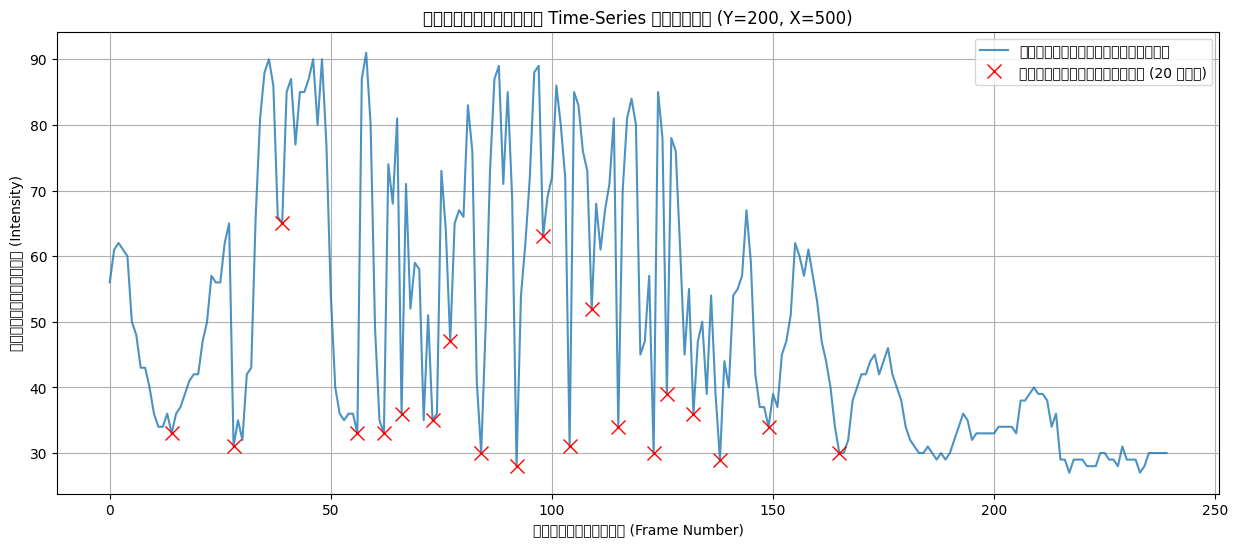

In [7]:
import cv2
import numpy as np
import glob
from scipy.signal import find_peaks
import os
import sys
import matplotlib.pyplot as plt # ใช้สำหรับพล็อต "หลักฐาน"

# --- 1. ตั้งค่า ---
image_path = r"C:\Users\Pannawit\Documents\GitHub\NARIT_Project\1tick_3\1tick_3"
file_pattern = os.path.join(image_path, "image_*.png")

# --- 2. โหลดไฟล์ทั้งหมด ---
file_list = glob.glob(file_pattern)
if not file_list:
    print(f"ไม่พบไฟล์ภาพใน: {image_path}")
    sys.exit("กรุณาตรวจสอบ path")

file_list.sort()
all_images = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in file_list]
print(f"พบไฟล์ทั้งหมด {len(all_images)} ไฟล์.")

if not all_images:
    print("ไม่สามารถโหลดภาพได้")
    sys.exit()

# --- 3. ตั้งค่า "เส้นชัย" (จุดพิกเซลเดียว) ---
# "นับแถวกลาง ๆ หน่อย"
h, w = all_images[0].shape
mid_y = h // 2
mid_x = w // 2 # ตีเส้นกลางจอไปเลย ง่ายดี

print(f"--- 🎯 ตั้งค่าจุดติดตาม (Sensor) ---")
print(f"ติดตามที่พิกัด: Y={mid_y}, X={mid_x}")

# --- 4. สร้าง Time-Series ของความสว่างที่จุดนั้น ---
# ดึงค่าความสว่างที่จุด (y, x) เดียว ตลอด 240 เฟรม
intensity_timeseries = [img[mid_y, mid_x] for img in all_images]
intensity_timeseries = np.array(intensity_timeseries)

# --- 5. วิเคราะห์ Time-Series เพื่อ "นับแถบมืด" ---
# "แถบมืด" คือ "หุบเขา" (local minima) ในกราฟ
# เราจะหา "ยอด" (peaks) ของกราฟที่กลับด้าน (-intensity_timeseries)

# ตั้งค่าพารามิเตอร์สำหรับ find_peaks
# ถ้า 240 เฟรม มี 50 แถบ -> แต่ละแถบใช้เวลา ~4.8 เฟรม
# distance: หุบเขาแต่ละอันต้องห่างกันอย่างน้อยกี่เฟรม (ป้องกันการนับ jitter)
MIN_FRAME_DISTANCE = 3 # ตั้งค่าน้อยๆ ไว้ก่อน

# prominence: หุบเขานั้นต้อง "ลึก" แค่ไหนถึงจะนับ
# (ป้องกันการนับ noise)
signal_range = np.max(intensity_timeseries) - np.min(intensity_timeseries)
MIN_PROMINENCE = signal_range * 0.25 # ต้องลึกอย่างน้อย 25% ของ range สัญญาณ

if signal_range == 0:
    print("เกิดข้อผิดพลาด: สัญญาณความสว่างไม่เปลี่ยนแปลงเลยตลอด 240 เฟรม!")
    sys.exit()

# หา "หุบเขา" (แถบมืด)
minima_indices, properties = find_peaks(-intensity_timeseries, 
                                        distance=MIN_FRAME_DISTANCE,
                                        prominence=MIN_PROMINENCE)

# --- 6. สรุปผล ---
count = len(minima_indices)

print(f"\n--- 📊 ผลการนับ (Event Counting) ---")
print(f"วิเคราะห์สัญญาณที่จุด (Y={mid_y}, X={mid_x})")
print(f"ตั้งค่า: หุบเขาต้องห่างกันอย่างน้อย {MIN_FRAME_DISTANCE} เฟรม")
print(f"ตั้งค่า: หุบเขาต้องลึกอย่างน้อย {MIN_PROMINENCE:.2f} (จาก 255)")
print("------------------------------------------")
print(f"จำนวนแถบมืดที่นับได้ (รวม): {count} แถบ")
print("------------------------------------------")

# "พิมพ์มาด้วยว่ารูปไหนนับแถบมืด"
print("\n🔍 รายการเฟรมที่ตรวจพบ 'แถบมืด' ผ่านจุดเซ็นเซอร์:")
for i in minima_indices:
    print(f"  - Frame {i:04d} (image_{i:04d}.png)")

# --- 7. ตีเส้นทับแถบมืด (พล็อตหลักฐาน) ---
# "ตีเส้นมาว่ามีเส้นทับแถบมืดจริง"
# ผมแสดงภาพนิ่ง 240 ภาพไม่ได้ แต่ผมพล็อตกราฟ 1D ให้ดูได้
# นี่คือ "หลักฐาน" ที่ดีที่สุดครับ

print("\nกำลังสร้างกราฟหลักฐานการนับ...")
plt.figure(figsize=(15, 6))
plt.title(f"การวิเคราะห์ Time-Series ที่จุด (Y={mid_y}, X={mid_x})")
plt.xlabel("หมายเลขเฟรม (Frame Number)")
plt.ylabel("ค่าความสว่าง (Intensity)")

# พล็อตกราฟสัญญาณดิบ
plt.plot(intensity_timeseries, label="สัญญาณความสว่างดิบ", alpha=0.8)

# "ตีเส้น" (จุดแดง) ทับ "แถบมืด" (หุบเขา) ที่นับได้
plt.plot(minima_indices, intensity_timeseries[minima_indices], "xr", 
         markersize=10, label=f"แถบมืดที่นับได้ ({count} จุด)")

plt.legend()
plt.grid(True)
plt.show()

พบไฟล์ทั้งหมด 240 ไฟล์.
--- 🎯 ตั้งค่าจุดติดตาม (Sensor) ---
ติดตามที่พิกัด: Y=200, X=500

--- 📊 ผลการนับ (Event Counting - เกณฑ์ต่ำ) ---
วิเคราะห์สัญญาณที่จุด (Y=200, X=500)
ตั้งค่า: หุบเขาต้องห่างกันอย่างน้อย 1 เฟรม
ตั้งค่า: หุบเขาต้องลึกอย่างน้อย 1.00
------------------------------------------
จำนวนแถบมืดที่นับได้ (รวม): 49 แถบ
------------------------------------------

🔍 รายการเฟรมที่ตรวจพบ 'แถบมืด' ผ่านจุดเซ็นเซอร์:
  - Frame 0011 (image_0011.png)
  - Frame 0014 (image_0014.png)
  - Frame 0024 (image_0024.png)
  - Frame 0028 (image_0028.png)
  - Frame 0030 (image_0030.png)
  - Frame 0039 (image_0039.png)
  - Frame 0042 (image_0042.png)
  - Frame 0047 (image_0047.png)
  - Frame 0053 (image_0053.png)
  - Frame 0056 (image_0056.png)
  - Frame 0062 (image_0062.png)
  - Frame 0064 (image_0064.png)
  - Frame 0066 (image_0066.png)
  - Frame 0068 (image_0068.png)
  - Frame 0071 (image_0071.png)
  - Frame 0073 (image_0073.png)
  - Frame 0077 (image_0077.png)
  - Frame 0080 (image_0080.png)

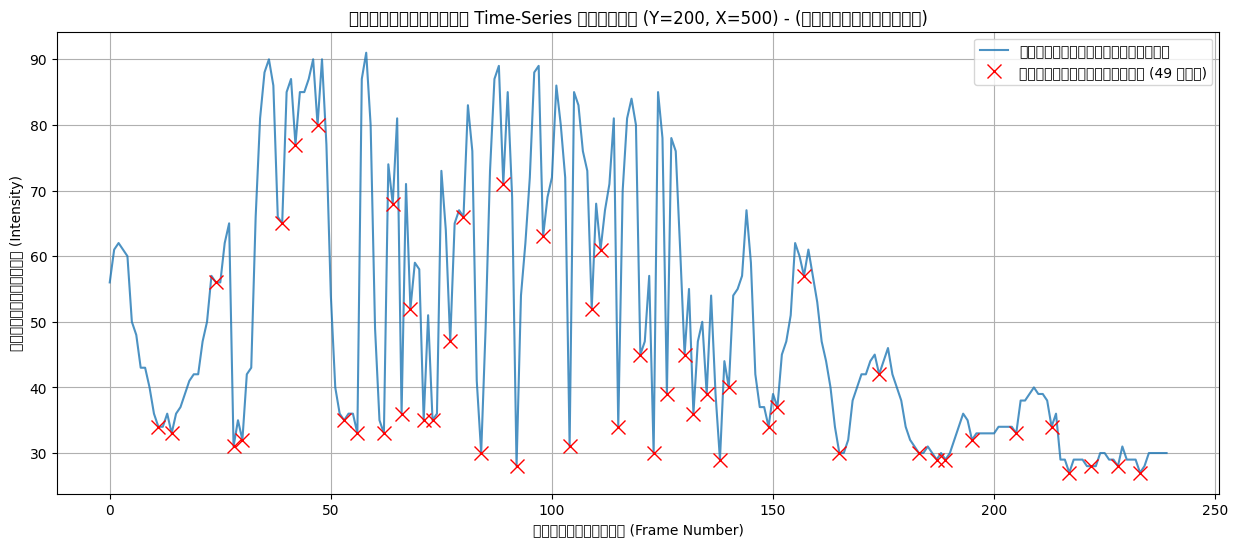

In [8]:
import cv2
import numpy as np
import glob
from scipy.signal import find_peaks
import os
import sys
import matplotlib.pyplot as plt

# --- 1. ตั้งค่า ---
image_path = r"C:\Users\Pannawit\Documents\GitHub\NARIT_Project\1tick_3\1tick_3"
file_pattern = os.path.join(image_path, "image_*.png")

# --- 2. โหลดไฟล์ทั้งหมด ---
file_list = glob.glob(file_pattern)
if not file_list:
    print(f"ไม่พบไฟล์ภาพใน: {image_path}")
    sys.exit("กรุณาตรวจสอบ path")

file_list.sort()
all_images = [cv2.imread(f, cv2.IMREAD_GRAYSCALE) for f in file_list]
print(f"พบไฟล์ทั้งหมด {len(all_images)} ไฟล์.")

if not all_images:
    print("ไม่สามารถโหลดภาพได้")
    sys.exit()

# --- 3. ตั้งค่า "เส้นชัย" (จุดพิกเซลเดียว) ---
h, w = all_images[0].shape
mid_y = h // 2
mid_x = w // 2 # ตีเส้นกลางจอ

print(f"--- 🎯 ตั้งค่าจุดติดตาม (Sensor) ---")
print(f"ติดตามที่พิกัด: Y={mid_y}, X={mid_x}")

# --- 4. สร้าง Time-Series ของความสว่างที่จุดนั้น ---
intensity_timeseries = [img[mid_y, mid_x] for img in all_images]
intensity_timeseries = np.array(intensity_timeseries)

# --- 5. วิเคราะห์ Time-Series เพื่อ "นับแถบมืด" ---
# "แถบมืด" คือ "หุบเขา" (local minima) ในกราฟ
# เราจะหา "ยอด" (peaks) ของกราฟที่กลับด้าน (-intensity_timeseries)

# ++++++++++++++++
#  การเปลี่ยนแปลง
# ++++++++++++++++
# ปรับเกณฑ์การนับให้นับ "ทุก" หุบเขาที่เจอ
#
# distance: หุบเขาต้องห่างกันอย่างน้อย 1 เฟรม (คือแค่ต่ำกว่าซ้ายขวาก็นับ)
MIN_FRAME_DISTANCE = 1 
#
# prominence: หุบเขานั้นต้อง "ลึก" แค่ไหน
# ปรับจาก (signal_range * 0.25) เป็น 1 (แค่ลึก 1 unit ก็นับ)
MIN_PROMINENCE = 1 
#
# ++++++++++++++++

if np.max(intensity_timeseries) == np.min(intensity_timeseries):
    print("เกิดข้อผิดพลาด: สัญญาณความสว่างไม่เปลี่ยนแปลงเลยตลอด 240 เฟรม!")
    sys.exit()

# หา "หุบเขา" (แถบมืด)
minima_indices, properties = find_peaks(-intensity_timeseries, 
                                        distance=MIN_FRAME_DISTANCE,
                                        prominence=MIN_PROMINENCE)

# --- 6. สรุปผล ---
count = len(minima_indices)

print(f"\n--- 📊 ผลการนับ (Event Counting - เกณฑ์ต่ำ) ---")
print(f"วิเคราะห์สัญญาณที่จุด (Y={mid_y}, X={mid_x})")
print(f"ตั้งค่า: หุบเขาต้องห่างกันอย่างน้อย {MIN_FRAME_DISTANCE} เฟรม")
print(f"ตั้งค่า: หุบเขาต้องลึกอย่างน้อย {MIN_PROMINENCE:.2f}")
print("------------------------------------------")
print(f"จำนวนแถบมืดที่นับได้ (รวม): {count} แถบ")
print("------------------------------------------")

print("\n🔍 รายการเฟรมที่ตรวจพบ 'แถบมืด' ผ่านจุดเซ็นเซอร์:")
for i in minima_indices:
    print(f"  - Frame {i:04d} (image_{i:04d}.png)")

# --- 7. ตีเส้นทับแถบมืด (พล็อตหลักฐาน) ---
print("\nกำลังสร้างกราฟหลักฐานการนับ...")
plt.figure(figsize=(15, 6))
plt.title(f"การวิเคราะห์ Time-Series ที่จุด (Y={mid_y}, X={mid_x}) - (นับทุกหุบเขา)")
plt.xlabel("หมายเลขเฟรม (Frame Number)")
plt.ylabel("ค่าความสว่าง (Intensity)")

# พล็อตกราฟสัญญาณดิบ
plt.plot(intensity_timeseries, label="สัญญาณความสว่างดิบ", alpha=0.8)

# "ตีเส้น" (จุดแดง) ทับ "แถบมืด" (หุบเขา) ที่นับได้
plt.plot(minima_indices, intensity_timeseries[minima_indices], "xr", 
         markersize=10, label=f"แถบมืดที่นับได้ ({count} จุด)")

plt.legend()
plt.grid(True)
plt.show()